In [140]:
import pandas as pd
from bs4 import BeautifulSoup as soup
import twint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from tqdm import tqdm
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [169]:
forexlive_data = pd.read_csv("data/ForexLive_1015.csv")
fxstreet_data = pd.read_csv("data/FXstreetNews_1015.csv")

In [170]:
tweet_data = pd.concat([forexlive_data, fxstreet_data])
tweet_data.shape

(247764, 36)

In [171]:
#removing extra columns
tweet_data = tweet_data[['date','tweet']]
tweet_data = tweet_data.sort_values('date').reset_index(drop = True)
#dropping duplicate values
tweet_data.drop_duplicates(keep = False, inplace = True)
tweet_data.to_csv("data/ForexData.csv", index = False)
tweet_data.shape

(247459, 2)

next we only want the tweets that are related to the  currency pair our model has been trained with. So we create a list of words containing those keywords and check which tweets have the data on those tw currency pairs

In [179]:
keywords = ['EU ', 'USA ','UK ','Europe', 'Euro ', 'EUR/USD', 'US ', 'London', 'America', 'Dollar', 'Euro ']
colum_list = ['date','tweet']
tweet_news = tweet_data[tweet_data[colum_list].stack().str.contains('|'.join(keywords), case=False, na=False).any(level=0)]
tweet_news.reset_index(drop=True)
tweet_news.shape

(51294, 2)

Remove all the links starting with either http or pic.twitter.com or https
Remove all the special characters, emoticons
Remove all the hashtags (#), @ symbol.
Remove words: ETMarkets, ndtv, moneycontrol, marketsupdate, biznews, NewsAlert, Click here for LIVE updates.
Remove all the numbers.

In [180]:
#Cleaning the tweets

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def clean(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'pic.twitter\S+', ' ', text)
    text = decontracted(text)
    text = re.sub(r'\(([^)]+)\)', " ", text)
    text = text.replace('etmarkets', ' ').replace('marketupdates', ' ').replace('newsalert', ' ').replace('ndtv', ' ').replace('moneycontrol', ' ').replace('here is why', ' ')
    text = text.replace('marketsupdate', ' ').replace('biznews', ' ').replace('click here', ' ').replace('live updates', ' ').replace('et now', ' ').replace('New blog post:',  ' ')
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    text = re.sub(r' \w{1,2}_', ' ', text)
    text = re.sub('\s+',' ', text)
    return text

In [185]:
for i in tqdm(tweet_news.itertuples()):
    tweet_news.at[i[0], 'tweet_processed'] = clean(i[2])

tweet_news.head(20)

2010it [00:00, 3767.06it/s]


,date,tweet_news_combined,tweet_processed
3,2010-01-03,new blog post sterling flexibility has aided u...,new blog post sterling flexibility has aided u...
13,2010-01-04,new blog post eur usd sees decent bounce mkt n...,new blog post eur usd sees decent bounce mkt n...
68,2010-01-05,new blog post us name heavy sellers of aud mkt...,new blog post us name heavy sellers of aud mkt...
127,2010-01-06,new blog post german econmin germany must rema...,new blog post german econmin germany must rema...
195,2010-01-07,new blog post eur usd lower on day usual suspe...,new blog post eur usd lower on day usual suspe...
259,2010-01-08,new blog post uk economy likely to be downgrad...,new blog post uk economy likely to be downgrad...
324,2010-01-09,new blog post forexlive us wrap up payrolls fa...,new blog post forexlive us wrap up payrolls fa...
328,2010-01-10,new blog post a race the dollar is glad to los...,new blog post a race the dollar is glad to los...
336,2010-01-11,new blog post snb is hildebrand snb to continu...,new blog post snb is hildebrand snb to continu...
401,2010-01-12,new blog post us yields on the slide mkt new b...,new blog post us yields on the slide mkt new b...


In [186]:
#combining all the tweets posted on a single date
tweet_news['tweet_news_combined'] = tweet_news.groupby(['date'])['tweet_processed'].transform(lambda x: ' '.join(x))

tweet_news.head(5)

,date,tweet_news_combined,tweet_processed
3,2010-01-03,new blog post sterling flexibility has aided u...,new blog post sterling flexibility has aided u...
13,2010-01-04,new blog post eur usd sees decent bounce mkt n...,new blog post eur usd sees decent bounce mkt n...
68,2010-01-05,new blog post us name heavy sellers of aud mkt...,new blog post us name heavy sellers of aud mkt...
127,2010-01-06,new blog post german econmin germany must rema...,new blog post german econmin germany must rema...
195,2010-01-07,new blog post eur usd lower on day usual suspe...,new blog post eur usd lower on day usual suspe...


In [187]:
tweet_news = tweet_news[['date', 'tweet_news_combined']]
tweet_news.drop_duplicates(inplace = True)
tweet_news.sort_values('date', inplace = True)
tweet_news.reset_index(drop = True)
tweet_news.tail(5)

,date,tweet_news_combined
247379,2015-12-26,uk rate hike in no longer priced in
247407,2015-12-28,the dollar index what the charts say socgen eu...
247504,2015-12-29,gbpusd sell off extends ahead of us data us c...
247626,2015-12-30,oil falls more than on unexpected us inventory...
247749,2015-12-31,why the new zealand dollar could soon come und...


In [194]:
tweet_news.to_csv('data/news_processed.csv', index =False)

In [195]:

tweet_news = pd.read_csv('data/news_processed.csv')

In [199]:
#next we want to add some new words to Vader Dictionary to judge fores markets better
new_words =  {'falls': -9, 'drops': -9, 'rise': 9, 'increases': 9, 'gain': 9, 'hiked': -9, 'dips': -9, 'declines': -9, 'decline': -9, 'hikes': -9, 'jumps': 9,
              'lose': -9, 'profit': 9, 'loss': -9, 'shreds': -9, 'sell': -9, 'buy': 9, 'recession': -9, 'weakens': -9, 'record low': -9, 'record high': 9,
              'bearish': -9, 'bulish': 9, 'climbs': 9, 'short': -9, 'long': 9, 'highs': 9, 'lows': -9, 'rises': 9, 'collapses': -9, 'improves to': 9, 'breaks above': 9, 'breaks below': -9 } 

analyser = SentimentIntensityAnalyzer()
analyser.lexicon.update(new_words)

for i in tqdm(tweet_news.itertuples()):
    score = analyser.polarity_scores(tweet_news.iloc[i[0]]['tweet_news_combined'])

    tweet_news.at[i[0], 'score'] = score['compound']

    if score['compound'] > 0:
        tweet_news.at[i[0], 'sentiment'] = 1
    elif score['compound'] == 0:
        tweet_news.at[i[0], 'sentiment'] = 0
    else:
        tweet_news.at[i[0], 'sentiment'] = -1

2010it [00:18, 110.32it/s]


In [201]:
tweet_news.head(20)

,date,tweet_news_combined,score,sentiment
0,2010-01-03,new blog post sterling flexibility has aided u...,-0.9325,-1.0
1,2010-01-04,new blog post eur usd sees decent bounce mkt n...,-0.9918,-1.0
2,2010-01-05,new blog post us name heavy sellers of aud mkt...,-0.0000,0.0
3,2010-01-06,new blog post german econmin germany must rema...,-0.9726,-1.0
4,2010-01-07,new blog post eur usd lower on day usual suspe...,-0.9652,-1.0
5,2010-01-08,new blog post uk economy likely to be downgrad...,0.9735,1.0
6,2010-01-09,new blog post forexlive us wrap up payrolls fa...,0.0000,0.0
7,2010-01-10,new blog post a race the dollar is glad to los...,-0.8689,-1.0
8,2010-01-11,new blog post snb is hildebrand snb to continu...,-0.9927,-1.0
9,2010-01-12,new blog post us yields on the slide mkt new b...,0.3737,1.0


In [203]:
tweet_news.to_csv("data/sentiments.csv", index=False)

Text(0.5, 1.0, 'Count Plot on Sentiment Variable')

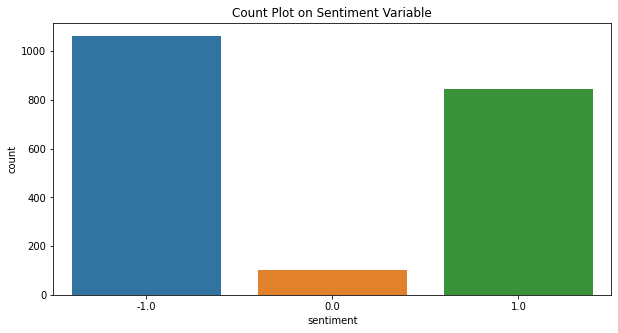

In [204]:
plt.figure(figsize=(10, 5))
sns.countplot(tweet_news['sentiment'])
plt.title('Count Plot on Sentiment Variable')


In [206]:
tweet_news = pd.read_csv("data/sentiments.csv")
tweet_news[['date','sentiment']].to_csv('data/EURUSD_Sentiments.csv', index=False)